In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# Load Dataset:

In [12]:
for_cover = pd.read_csv('Data/covtype.csv')
cover_dict = {1 : "Spruce/ Fir", 2 : "Lodgepole Pine", 3 : "Ponderosa Pine", 4 : "Cottonwood/ Willow", 
              5 : "Aspen", 6 : "Douglas-fir", 7 : "Krummholz"}
for_cover['cover_name'] = for_cover['Cover_Type'].map(cover_dict)

In [13]:
for_cover.head(3)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,cover_name
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,5,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,5,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,2,Lodgepole Pine


# Splitting Train and Test Set:

In [14]:
X = for_cover.drop(['Cover_Type', 'cover_name'], axis=1)

In [5]:
y = for_cover['Cover_Type']

In [6]:
# We will use the following seed to be able to replicate the randomness:
seed = 42

In [7]:
# We will use a random test split size of 20%, stratified to retain the same proportions of classes as the training set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed, stratify = y)

In [8]:
print("X_train Length: {:,}".format(len(X_train)))
print("X_test Length:  {:,}".format(len(X_test)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("y_train Length: {:,}".format(len(y_train)))
print("y_test Length:  {:,}".format(len(y_test)))

X_train Length: 464,809
X_test Length:  116,203
~~~~~~~~~~~~~~~~~~~~~~~~
y_train Length: 464,809
y_test Length:  116,203


In [14]:
# Saving Training Set and Test set:
X_train.to_csv('Data/X_train.csv', index=False, header=True)
X_test.to_csv('Data/X_test.csv', index=False, header=True)

y_train.to_csv('Data/y_train.csv', index=False, header=False)
y_test.to_csv('Data/y_test.csv', index=False, header=False)

## Creating validation set to use for MLP:
- We will separate a validation set from the training data, to use to validate our MLP model within epochs.
- Again, the set will be stratified to ensure it contains the same proportion of target classes as the test and training set.


In [9]:
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify=y_train, random_state=seed)

In [10]:
print("X_train (MLP) Length: {:,}".format(len(X_train_mlp)))
print("X_val (MLP) Length:   {:,}".format(len(X_val_mlp)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("y_train (MLP) Length: {:,}".format(len(y_train_mlp)))
print("y_val (MLP) Length:   {:,}".format(len(y_val_mlp)))

X_train (MLP) Length: 371,847
X_val (MLP) Length:   92,962
~~~~~~~~~~~~~~~~~~~~~~~~
y_train (MLP) Length: 371,847
y_val (MLP) Length:   92,962


## Saving datasets:

In [19]:
X_train_mlp.to_csv('Data/X_train_mlp.csv', index=False, header=True)
X_val_mlp.to_csv('Data/X_val_mlp.csv', index=False, header=True)
y_train_mlp.to_csv('Data/y_train_mlp.csv', index=False, header=False)
y_val_mlp.to_csv('Data/y_val_mlp.csv', index=False, header=False)

# Plot showing class distribution across training and test sets:

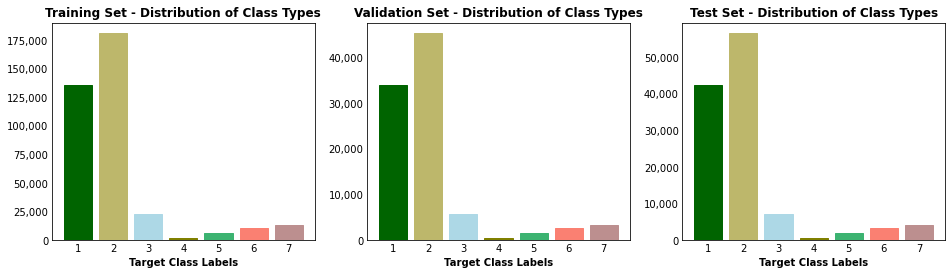

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
plt.rcParams['axes.facecolor'] = 'white'
colors = ['darkgreen', 'darkkhaki', 'lightblue', 'olive', 'mediumseagreen', 'salmon', 'rosybrown']
y_train_counts = y_train_mlp.value_counts().reset_index().rename(columns={'index': 'cover_num'}).sort_values('cover_num')
y_val_counts = y_val_mlp.value_counts().reset_index().rename(columns={'index': 'cover_num'}).sort_values('cover_num')
y_test_counts = y_test.value_counts().reset_index().rename(columns={'index': 'cover_num'}).sort_values('cover_num')

bars = ax[0].bar(y_train_counts.cover_num, y_train_counts.Cover_Type)
bars1 = ax[1].bar(y_val_counts.cover_num, y_val_counts.Cover_Type)
bars2 = ax[2].bar(y_test_counts.cover_num, y_test_counts.Cover_Type)

# Setting bar colour individually:
for i in range (len(y_train_counts.cover_num)):
    bars[i].set_color(colors[i])
    bars1[i].set_color(colors[i])
    bars2[i].set_color(colors[i])

tt = ["Training", "Validation", "Test"]
for i in range(3):
    ax[i].set_title('%s Set - Distribution of Class Types' % (tt[i]), fontweight = 'bold')
    # Including comma's for y axis labels - source (https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib/46574866)
    ax[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].tick_params(axis=u'both', which=u'both',length=0) 
    ax[i].set_xlabel("Target Class Labels", fontweight = 'bold')
    ax[i].grid("")
    
plt.show()